# README: Modelo Final - Predição de Temperatura Interna

Este notebook realiza a avaliação e interpretação de modelos de regressão para predição da temperatura interna em experimentos de exercício físico. Ele utiliza diferentes algoritmos (Lasso, DecisionTree, RandomForest, XGBoost) e conjuntos de features, compara o desempenho dos modelos e apresenta gráficos de interpretabilidade (SHAP).

## Estrutura do Notebook
- **1. Setup e Importação de Bibliotecas**: Importa todas as dependências necessárias.
- **2. Carregamento e Preparação dos Dados**: Função para carregar o dataset e preparar os dados para modelagem.
- **3. Definição dos Hiperparâmetros Otimizados**: Dicionário com os melhores parâmetros para cada modelo e conjunto de features.
- **4. Avaliação dos Modelos**: Executa validação cruzada, coleta métricas e gera gráficos comparativos.
- **5. Interpretação dos Resultados**: Apresenta gráficos de desempenho e análise SHAP para o melhor modelo.

## Como usar
1. Ajuste o caminho do arquivo de dados na função `carregar_dados()` se necessário.
2. Execute as células sequencialmente para obter os resultados e gráficos.
3. Os gráficos e tabelas finais mostram o desempenho dos modelos e a importância das variáveis.

## Observações
- O notebook está organizado em células separadas por seções comentadas.
- O código foi refatorado para facilitar manutenção e entendimento.
- Para dúvidas ou melhorias, consulte o README ou os comentários no código.


In [1]:
# =============================================================================
# 1. SETUP E IMPORTAÇÃO DE BIBLIOTECAS
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Modelos e pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Validação e métricas
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error


In [2]:
# =============================================================================
# 2. DEFINIÇÃO DOS CONJUNTOS DE FEATURES
# =============================================================================
# Defina os conjuntos de features utilizados nos experimentos
TARGET = 'interna'
FEATURE_SETS = {
    'simple': ['km', 'ibutg', 'pele', 'fc'],
    'simple_com_velocidade': ['km', 'ibutg', 'pele', 'fc', 'velocidade'],
    'ambiental_completo': ['km', 'ibutg', 'umidade_absoluta', 'umidade_relativa',
                           'ambiente_seca', 'ambiente_umida', 'pele', 'fc']
}

# ...existing code...

In [3]:
# =============================================================================
# 2. CARREGAMENTO E PREPARAÇÃO DOS DADOS
# =============================================================================
# Carregue o dataset e defina X, y e groups conforme necessário
df = pd.read_csv('/home/usuario-leticia/Desktop/Samuel/leticiaag/tcore/data/dados-organizados-1-1km.csv')  # ajuste o caminho se necessário
X = df.drop(columns=[TARGET, 'trial_id'])
y = df[TARGET]
groups = df['trial_id']
cv_splitter = GroupKFold(n_splits=5)


In [4]:
# =============================================================================
# 3. DEFINIÇÃO DOS HIPERPARÂMETROS OTIMIZADOS
# =============================================================================
OPTIMIZED_PARAMS = {
    'Lasso': {
        'simple': {'alpha': 0.02868},
        'simple_com_velocidade': {'alpha': 0.02394},
        'ambiental_completo': {'alpha': 0.02631}
    },
    'DecisionTree': {
        'simple': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'simple_com_velocidade': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'ambiental_completo': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5}
    },
    'RandomForest': {
        'simple': {'max_features': 0.8, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'simple_com_velocidade': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'ambiental_completo': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 400}
    },
    'XGBoost': {
        'simple': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 6, 'subsample': 0.5},
        'simple_com_velocidade': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5},
        'ambiental_completo': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5}
    }
}


In [5]:
# =============================================================================
# 4. EXECUÇÃO DO EXPERIMENTO DE AVALIAÇÃO
# =============================================================================
resultados_finais = []
scoring = {
    'r2': 'r2',
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

print("\n--- Iniciando a avaliação dos modelos com hiperparâmetros otimizados ---")

for feature_set_name, feature_list in FEATURE_SETS.items():
    print(f"\n>>> Avaliando com o conjunto de features: '{feature_set_name}'")
    X_subset = X[feature_list]

    # Avaliação do Lasso (sempre escalonado)
    print("    - Avaliando: Lasso_Scaled")
    lasso_params = OPTIMIZED_PARAMS['Lasso'][feature_set_name]
    pipeline_lasso = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=42, max_iter=20000, **lasso_params))
    ])
    scores = cross_validate(pipeline_lasso, X_subset, y, cv=cv_splitter, scoring=scoring, groups=groups, return_train_score=True)
    resultados_finais.append({
        'model': 'Lasso', 'feature_set': feature_set_name, 'scaled': True,
        'R2_treino': np.mean(scores['train_r2']), 'R2_teste': np.mean(scores['test_r2']),
        'RMSE_treino': -np.mean(scores['train_rmse']), 'RMSE_teste': -np.mean(scores['test_rmse'])
    })

    # Avaliação dos modelos de árvore (apenas NÃO escalonados)
    for model_name in ['DecisionTree', 'RandomForest', 'XGBoost']:
        params = OPTIMIZED_PARAMS[model_name][feature_set_name]
        model_instance = None
        if model_name == 'DecisionTree':
            model_instance = DecisionTreeRegressor(random_state=42, **params)
        elif model_name == 'RandomForest':
            model_instance = RandomForestRegressor(random_state=42, **params)
        elif model_name == 'XGBoost':
            model_instance = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params)

        if model_instance is not None:
            # Não escalonado
            print(f"    - Avaliando: {model_name}_Unscaled")
            pipeline_unscaled = Pipeline([
                ('model', model_instance)
            ])
            scores_unscaled = cross_validate(pipeline_unscaled, X_subset, y, cv=cv_splitter, scoring=scoring, groups=groups, return_train_score=True)
            resultados_finais.append({
                'model': model_name, 'feature_set': feature_set_name, 'scaled': False,
                'R2_treino': np.mean(scores_unscaled['train_r2']), 'R2_teste': np.mean(scores_unscaled['test_r2']),
                'RMSE_treino': -np.mean(scores_unscaled['train_rmse']), 'RMSE_teste': -np.mean(scores_unscaled['test_rmse'])
            })
            # Modelos de árvore com dados escalonados foram removidos

    # Modelos Lasso não escalonados foram removidos



--- Iniciando a avaliação dos modelos com hiperparâmetros otimizados ---

>>> Avaliando com o conjunto de features: 'simple'
    - Avaliando: Lasso_Scaled
    - Avaliando: DecisionTree_Unscaled
    - Avaliando: RandomForest_Unscaled
    - Avaliando: XGBoost_Unscaled

>>> Avaliando com o conjunto de features: 'simple_com_velocidade'
    - Avaliando: Lasso_Scaled
    - Avaliando: DecisionTree_Unscaled
    - Avaliando: RandomForest_Unscaled
    - Avaliando: XGBoost_Unscaled

>>> Avaliando com o conjunto de features: 'ambiental_completo'
    - Avaliando: Lasso_Scaled
    - Avaliando: DecisionTree_Unscaled
    - Avaliando: RandomForest_Unscaled
    - Avaliando: XGBoost_Unscaled



--- Avaliação concluída ---


,experimento,R2_treino,R2_teste,RMSE_treino,RMSE_teste
0,DecisionTree (simple_com_velocidade),0.818447,0.764030,0.407068,0.462777
1,DecisionTree (simple),0.817005,0.766426,0.408696,0.460868
2,DecisionTree (ambiental_completo),0.817681,0.768780,0.407944,0.458381
3,XGBoost (simple_com_velocidade),0.860588,0.797841,0.356655,0.428470
4,RandomForest (simple),0.846892,0.801762,0.373833,0.424392
5,XGBoost (simple),0.860523,0.801959,0.356785,0.424308
6,RandomForest (ambiental_completo),0.851958,0.802453,0.367598,0.423494
7,Lasso (ambiental_completo),0.812921,0.802784,0.413208,0.423018
8,Lasso (simple),0.810094,0.804452,0.416336,0.421392
9,XGBoost (ambiental_completo),0.857647,0.805199,0.360454,0.420635


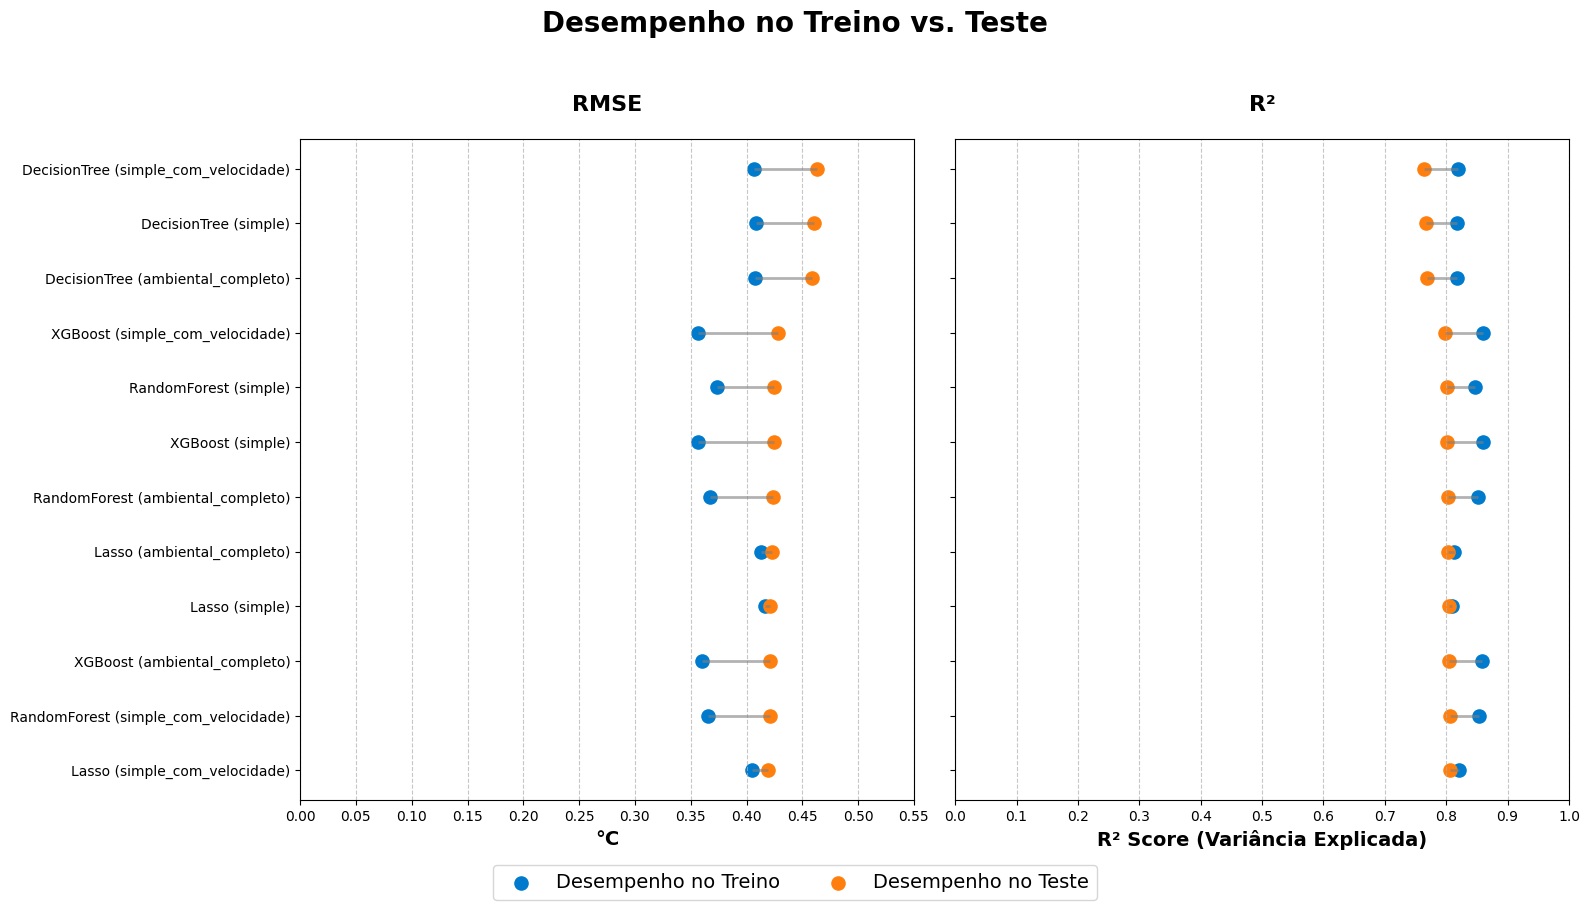

In [6]:
# =============================================================================
# 5. VISUALIZAÇÃO DOS RESULTADOS E ANÁLISE DE INTERPRETABILIDADE
# =============================================================================
# Tabela de resultados
results_df = pd.DataFrame(resultados_finais)
results_df['experimento'] = results_df['model'] + ' (' + results_df['feature_set'] + ')'
results_df_sorted = results_df.sort_values('RMSE_teste', ascending=False).reset_index(drop=True)

print("\n--- Avaliação concluída ---")
display(results_df_sorted[['experimento', 'R2_treino', 'R2_teste', 'RMSE_treino', 'RMSE_teste']])

# --- Criação do Gráfico de Halteres (Dumbbell Plot) para RMSE e R² ---
fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharey=True)

# --- Gráfico de RMSE (Esquerda) ---
ax1 = axes[0]
ax1.hlines(y=results_df_sorted.index, 
           xmin=results_df_sorted['RMSE_treino'], 
           xmax=results_df_sorted['RMSE_teste'], 
           color='grey', alpha=0.6, linewidth=2)
ax1.scatter(results_df_sorted['RMSE_treino'], results_df_sorted.index, 
            color='#007acc', alpha=1, s=90, label='Desempenho no Treino')
ax1.scatter(results_df_sorted['RMSE_teste'], results_df_sorted.index, 
            color='#ff7f0e', alpha=1, s=90, label='Desempenho no Teste')
ax1.set_xlabel('°C', fontsize=14, weight='bold')
ax1.set_title('RMSE', fontsize=16, weight='bold', pad=20)
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.set_xticks(np.arange(0.0, 0.57, 0.05))

# --- Gráfico de R² (Direita) ---
ax2 = axes[1]
ax2.hlines(y=results_df_sorted.index, 
           xmin=results_df_sorted['R2_treino'], 
           xmax=results_df_sorted['R2_teste'], 
           color='grey', alpha=0.6, linewidth=2)
ax2.scatter(results_df_sorted['R2_treino'], results_df_sorted.index, 
            color='#007acc', alpha=1, s=90)
ax2.scatter(results_df_sorted['R2_teste'], results_df_sorted.index, 
            color='#ff7f0e', alpha=1, s=90)
ax2.set_xlabel('R² Score (Variância Explicada)', fontsize=14, weight='bold')
ax2.set_title('R²', fontsize=16, weight='bold', pad=20)
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.set_xticks(np.arange(0.0, 1.05, 0.1))

# --- Configurações Comuns ---
# Adicionar os nomes dos experimentos no eixo Y (apenas no primeiro gráfico)
plt.yticks(results_df_sorted.index, results_df_sorted['experimento'], fontsize=12)

# Inverter o eixo Y para colocar o melhor resultado (menor RMSE) no topo
ax1.invert_yaxis()

# Adicionar uma única legenda para a figura inteira
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=14, frameon=True)

# Título geral
fig.suptitle('Desempenho no Treino vs. Teste', fontsize=20, weight='bold', y=0.98)

plt.tight_layout(rect=[0.0, 0.03, 1, 0.95]) # Ajustar layout para o título e legenda
plt.show()



--- Análise de Interpretabilidade com SHAP ---
Melhor combinação global encontrada: Lasso (simple_com_velocidade)
  - R² Teste: 0.8066
  - RMSE Teste: 0.4191

Melhor modelo otimizado treinado com todos os dados.
Calculando os valores SHAP...
Gerando gráficos SHAP...


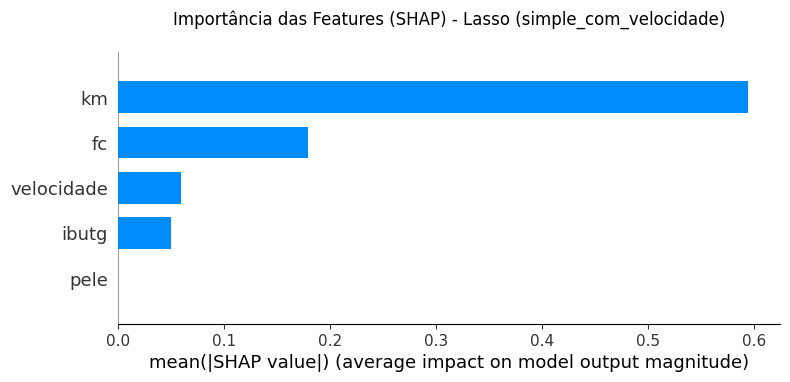

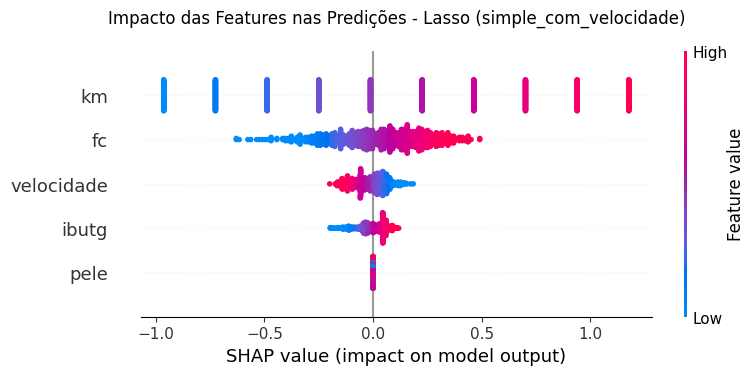

In [10]:
# =============================================================================
# 6. ANÁLISE DE INTERPRETABILIDADE (SHAP) COM O MELHOR MODELO
# =============================================================================
print("\n--- Análise de Interpretabilidade com SHAP ---")

# Seleciona o melhor experimento com base no menor RMSE de teste
best_experiment = results_df.sort_values('RMSE_teste').iloc[0]
best_model_name = best_experiment['model']
best_feature_set_name = best_experiment['feature_set']
best_params = OPTIMIZED_PARAMS[best_model_name][best_feature_set_name]
best_was_scaled = best_experiment['scaled']

print(f"Melhor combinação global encontrada: {best_experiment['experimento']}")
print(f"  - R² Teste: {best_experiment['R2_teste']:.4f}")
print(f"  - RMSE Teste: {best_experiment['RMSE_teste']:.4f}")

# Instancia o modelo final com os melhores parâmetros
if best_model_name == 'Lasso':
    final_model_instance = Lasso(random_state=42, max_iter=20000, **best_params)
elif best_model_name == 'DecisionTree':
    final_model_instance = DecisionTreeRegressor(random_state=42, **best_params)
elif best_model_name == 'RandomForest':
    final_model_instance = RandomForestRegressor(random_state=42, **best_params)
elif best_model_name == 'XGBoost':
    final_model_instance = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

# Pipeline final
best_features = FEATURE_SETS[best_feature_set_name]
X_best = X[best_features]
if best_was_scaled:
    final_pipeline = Pipeline([('scaler', StandardScaler()), ('model', final_model_instance)])
else:
    final_pipeline = Pipeline([('model', final_model_instance)])

# Treina o modelo final
final_pipeline.fit(X_best, y)
print("\nMelhor modelo otimizado treinado com todos os dados.")

# Prepara dados para SHAP
X_shap = X_best
if best_was_scaled:
    X_shap = pd.DataFrame(final_pipeline.named_steps['scaler'].transform(X_best), columns=best_features)

# Explainer SHAP
model_fitted = final_pipeline.named_steps['model']
explainer = None
if best_model_name in ['DecisionTree', 'RandomForest', 'XGBoost']:
    explainer = shap.TreeExplainer(model_fitted)
elif best_model_name == 'Lasso':
    explainer = shap.LinearExplainer(model_fitted, X_shap)

if explainer:
    print("Calculando os valores SHAP...")
    shap_values = explainer.shap_values(X_shap)
    print("Gerando gráficos SHAP...")
    # Importância das features
    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
    plt.title(f'Importância das Features (SHAP) - {best_experiment["experimento"]}', pad=20)
    plt.show()
    # Impacto das features
    plt.figure()
    shap.summary_plot(shap_values, X_shap, show=False)
    plt.title(f'Impacto das Features nas Predições - {best_experiment["experimento"]}', pad=20)
    plt.show()
else:
    print(f"Análise SHAP não implementada para o tipo de modelo: {best_model_name}")
